# CoaT small parallel

In [1]:
CURRENT_FOLD = 3

# imports

In [2]:
import random
from pathlib import Path

import numpy as np
import pandas as pd
import cv2 as cv
import os

from matplotlib import pyplot as plt
from glob import glob
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from IPython.display import clear_output

import albumentations as A
import albumentations.pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.swa_utils import AveragedModel, SWALR

import torch.cuda.amp as amp
is_amp = True

# data

In [3]:
ORGAN2ID = {
    'kidney' : 0,
    'prostate' : 1,
    'largeintestine' : 2,
    'spleen' : 3,
    'lung' : 4
}
ID2ORGAN = {v: k for k, v in ORGAN2ID.items()}

In [4]:
PATCH_SIZE = 768

# model testing

In [5]:
from model_coat_daformer import *
from coat import *

In [6]:
encoder = coat_parallel_small

model = Net(encoder=encoder, decoder=None, n_classes=3)

In [7]:
sample_input = torch.randn(1, 3, 768, 768)

In [8]:
sample_mask = torch.tensor([[0, 1], [1, 0]], dtype=torch.float).repeat(8, 8)

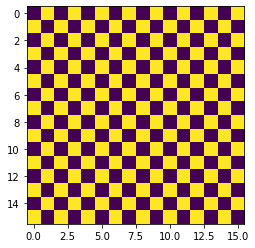

In [9]:
plt.imshow(sample_mask)
plt.show()

In [10]:
sample_mask = sample_mask.unsqueeze(0).unsqueeze(1)

In [11]:
sample_output = model.forward_mae({'image': sample_input, 
                                   'mae_mask': sample_mask,
                                   'organ': [1]})

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [12]:
sample_output.keys()

dict_keys(['logits', 'loss'])

In [13]:
for key in sample_output.keys():
    print(key, sample_output[key].shape)

logits torch.Size([1, 3, 192, 192])
loss torch.Size([])


## data 768

In [14]:
mean = np.array([0.0, 0.0, 0.0])
std = np.array([1.0, 1.0, 1.0])

In [15]:
train_transform= A.Compose([
#     A.Resize(512, 512, interpolation=cv.INTER_LINEAR),
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.RandomRotate90(p=0.5),
#     A.HueSaturationValue(p=0.25),
#     A.ShiftScaleRotate(shift_limit=0.02, scale_limit=(-0.1, 0.7),rotate_limit=90, p=0.5),
#     A.ElasticTransform(p=0.2, alpha=90, sigma=120 * 0.05, alpha_affine=120 * 0.03),
#     A.ElasticTransform(p=0.5, alpha=90, sigma=120*0.7, alpha_affine=120 * 0.8),
    
#     A.GridDistortion(p=0.25),
#     A.Blur(blur_limit=7, p=0.1),
#     A.GaussNoise(var_limit=(20, 100), p=0.4),
#     A.ChannelDropout(p=0.05),
#     A.RandomGamma(p=0.1),
#     A.RandomBrightnessContrast(p=0.2),
    A.RandomResizedCrop(768, 768, scale=(
                    0.5, 1.0), interpolation=3, p=1),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], 
                max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [16]:
val_transform = A.Compose([
#     A.Resize(512, 512, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1],
                 max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [17]:
def gen_random_mask(shape, ratio_keep=0.6):
    mask = np.ones(shape[0] * shape[1], dtype=np.float32)
    N = len(mask)
    mask[:int(N * ratio_keep)] = 0.0
    np.random.shuffle(mask)
    mask = mask.reshape(shape[0], shape[1])
    return mask

In [18]:
class HubmapDatasetSimMIM(Dataset):
    def __init__(self, path_to_images, transform=None):

        self.path_to_images = path_to_images
        self.images = list(sorted(glob(os.path.join(path_to_images, '*/*.png'))))
        self.transform = transform
        self.length = len(self.images)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        fname = self.images[index]
        image = cv.cvtColor(cv.imread(fname), cv.COLOR_BGR2RGB) # .astype(np.float32) / 255.0
        
        dice = np.random.uniform()
        if dice < 0.5:
            mae_mask = gen_random_mask((16, 16), ratio_keep=0.5)
        elif dice < 0.7:
            mae_mask = gen_random_mask((24, 24), ratio_keep=0.5)
        elif dice < 0.9:
            mae_mask = gen_random_mask((32, 32), ratio_keep=0.5)
        else:
            mae_mask = gen_random_mask((8, 8), ratio_keep=0.5)
            
        mae_mask = cv.resize(mae_mask, (96, 96), interpolation=cv.INTER_NEAREST)
            
        organ = os.path.basename(fname).split('_')[0]
        organid = ORGAN2ID[organ]
        
        data = {
            'image': image,
            'mae_mask': mae_mask,
            'organ': organid
        }
        upd_data = self.transform(image=data['image'])

        data.update(upd_data)
        return data

In [19]:
def worker_init_fn(worker_id):
    torch_seed = torch.initial_seed()
    random.seed(torch_seed + worker_id)
    if torch_seed >= 2**30:  # make sure torch_seed + workder_id < 2**32
        torch_seed = torch_seed % 2**30
    np.random.seed(torch_seed + worker_id)
    random.seed(torch_seed + worker_id + 77777)

In [20]:
train_dataset = HubmapDatasetSimMIM('./../data/SIMMIM/', train_transform)

IMAGE
torch.Size([3, 768, 768])
image values:  0.05490196496248245 1.0


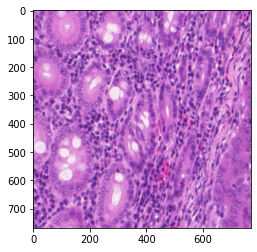

MASK
(96, 96)
mask values:  0.0 1.0


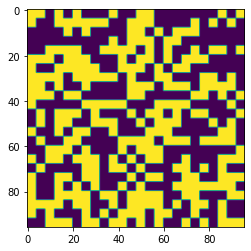

In [21]:
sample = train_dataset[1]
print('IMAGE')
print(sample['image'].shape)
print('image values: ', float(sample['image'].min()), float(sample['image'].max()))
plt.imshow(sample['image'].permute((1, 2, 0)))
plt.show()

print('MASK')
print(sample['mae_mask'].shape)
print('mask values: ', sample['mae_mask'].min(), sample['mae_mask'].max())
plt.imshow(sample['mae_mask'])
plt.show()

In [22]:
BATCH_SIZE = 6

In [23]:
loader_params = {'shuffle': True,
                 'num_workers': 0,
                 'worker_init_fn': worker_init_fn}
loader_train = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          worker_init_fn=worker_init_fn,
                          num_workers=12
                         )

# model

In [24]:
!nvidia-smi

Sun Sep  4 23:32:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.152.00   Driver Version: 418.152.00   CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   44C    P0    40W / 300W |     57MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   45C    P0    54W / 300W |   1905MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [25]:
device = 'cuda:2'
DEVICE = device

In [26]:
encoder = coat_parallel_small
decoder = None

model = Net(encoder=encoder, decoder=None, n_classes=3).to(device)

In [27]:
model.encoder.load_state_dict(torch.load('./../coat-first-try/coat_small_7479cf9b.pth')['model'], strict=False)

_IncompatibleKeys(missing_keys=['org_tokens1', 'org_tokens2', 'org_tokens3', 'org_tokens4', 'mask_token'], unexpected_keys=['norm1.weight', 'norm1.bias', 'norm2.weight', 'norm2.bias', 'norm3.weight', 'norm3.bias', 'norm4.weight', 'norm4.bias', 'aggregate.weight', 'aggregate.bias', 'head.weight', 'head.bias'])

# lr schedule

In [47]:
def lr_function(step):
    start_lr = 1e-5; min_lr = 1e-5; max_lr = 5e-4    #A
    rampup_epochs = 200; sustain_epochs = 20000; exp_decay = 0.99994    #B
 
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs,
           sustain_epochs, exp_decay):
        if epoch < rampup_epochs:    #C
            lr = ((max_lr - start_lr) / rampup_epochs
                        * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:    #D
            lr = max_lr
        else:    #E
            lr = max((max_lr - min_lr) *
                      exp_decay**(epoch - rampup_epochs -
                                    sustain_epochs)* (0.8+0.01*np.sin(epoch / 100)), 0) + min_lr
        return lr
 
    return lr(step, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay) / max_lr

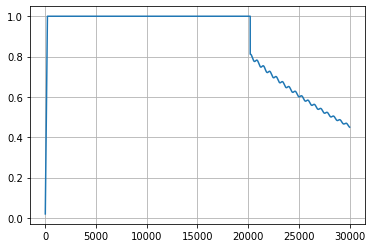

In [48]:
xxx = []
for i in range(30000):
    xxx.append(lr_function(i))
    
plt.plot(xxx)
plt.grid()
plt.show()

# Criterions

In [30]:
# import segmentation_models_pytorch as smp

In [31]:
# l1loss = nn.L1Loss()
# l2loss = nn.MSELoss()
# def criterion(pred, true):
#     return  0.98 * l1loss(pred, true) + 0.02 * l2loss(pred, true)

# validation code

In [32]:
import monai
from monai.utils.enums import BlendMode, PytorchPadMode
from monai.inferers import sliding_window_inference

In [33]:
# class Predictor(nn.Module):
#     def __init__(self, model):
#         super().__init__()
#         self.model = model
    
#     def forward(self, x):
#         _, _, H, W = x.shape
#         H = int(H)
#         W = int(W)
        
#         mae_mask = gen_random_mask((32, 32), ratio_keep=0.3)
#         mae_mask = cv.resize(mae_mask, dsize=(H//4, W//4), interpolation=cv.INTER_NEAREST)
#         mae_mask = torch.tensor(mae_mask).unsqueeze(0).unsqueeze(1).to(device)
        
        
#         out = self.model.forward_mae({'image' : x, 'mae_mask': mae_mask})
# #         print(out.keys())
# #         img = F.interpolate(out['logits'], size=(512, 512))
#         return out['logits']

In [34]:
# def infer_id(predictor, id: str, organ: str, pixel_size=0.4):
    
#     image = cv.imread('./../data/train_images/{}.tiff'.format(id))
#     image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    
#     scale_factor = 0.5 * (pixel_size / 0.4)
#     image = cv.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv.INTER_AREA)
    
#     masks = []
        
#     image_tensor = val_transform(image=image)['image']

#     image_tensor = image_tensor.unsqueeze(0).to(device)

#     with torch.no_grad():
#         infer_result = sliding_window_inference(
#             image_tensor, roi_size=(768, 768), sw_batch_size=2, predictor=predictor, 
#             overlap=0.5, mode=BlendMode.CONSTANT, sigma_scale=0.125, 
#             padding_mode=PytorchPadMode.CONSTANT, cval=0.0,       
#         )

    
#     pr_img = infer_result.detach().cpu().numpy()[0].transpose((1, 2, 0)).astype(np.float32)
    
# #     print(pr_img.shape)
        
#     pr_img = cv.resize(pr_img, dsize=image.shape[:2], interpolation=cv.INTER_NEAREST)
    
#     return pr_img, image.astype(np.float32) / 255.0

In [35]:
# def validate(val_df, model):
#     predictor = Predictor(model)
    
#     mae_losses = []
    
#     by_organ_mae_losses = {key:[] for key in ORGAN2ID.keys()}
#     for index, row in tqdm(val_df.iterrows(), total=len(val_df)):
#         id = row['id']
#         organ = row['organ']
#         pixel_size = row['pixel_size']
#         pred_img, gt_img = infer_id(predictor, id, organ=organ, pixel_size=pixel_size)
#         mae_loss = np.abs(pred_img - gt_img).mean()
#         mae_losses.append(mae_loss)
#         by_organ_mae_losses[organ].append(mae_loss)
#     new_record = dict()
#     new_record['dices'] = mae_losses
#     new_record['by_organ'] = by_organ_mae_losses
#     return new_record

In [36]:
# val_df_id = train_df[train_df['fold'] == CURRENT_FOLD]

# training

In [49]:
learning_rate = 2.5e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=5e-2)

In [38]:
scaler = amp.GradScaler(enabled = is_amp)

In [50]:
scheduler_warmup = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_function)

In [40]:
train_loss = []
accuracy = [] 
lr_hist = []

In [41]:
PTH = './checkpoint_pretrain_fold_{}'.format(CURRENT_FOLD)

In [42]:
Path(PTH).mkdir(parents=True, exist_ok=True)

In [43]:
logfile = open(PTH + '/log.train.txt', mode='a')
logfile.write('\n--- [START %s] %s\n\n' % ('coat-small pretrain', '-' * 64))

99

In [44]:
def log(string):
    print(string)
    logfile.write(string + '\n')

In [45]:
N_EPOCHS = 450
global_it = 0
VIRTUAL_BATCH_SIZE = 4

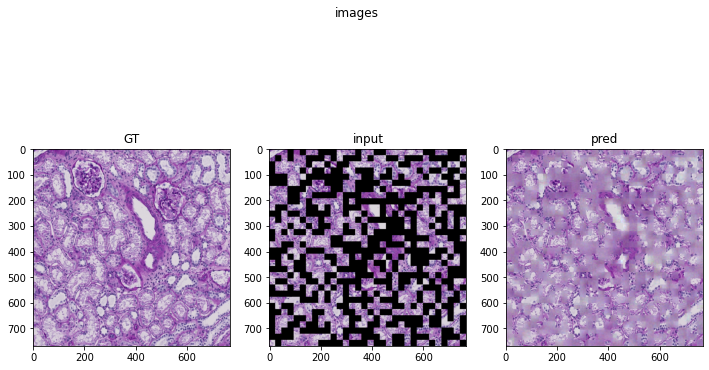

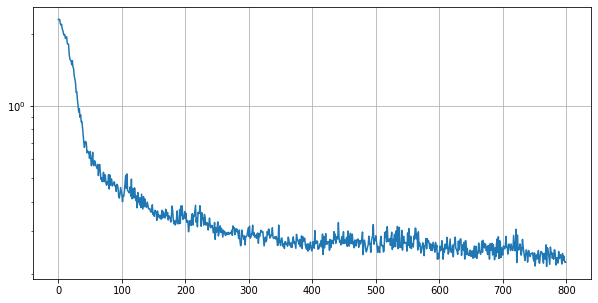

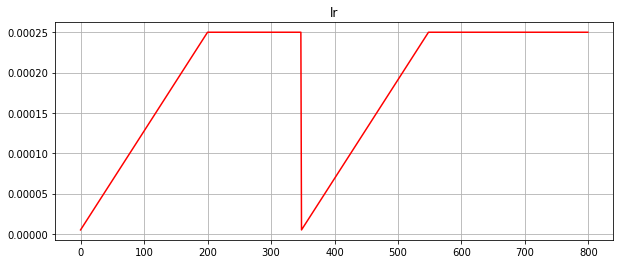

==> Epoch 2 (220/1593) | loss: 0.23304
==> Epoch 2 (228/1593) | loss: 0.25425
==> Epoch 2 (236/1593) | loss: 0.20793


In [ ]:
for epoch in range(0, N_EPOCHS):
   
    model.train()
    
    batch_train_loss = []
    
    for iteration, batch in enumerate(loader_train):
        global_it += 1
#         print(batch['mae_mask'].shape)
        batch['image'] = batch['image'].half().to(device)
        batch['mae_mask'] = batch['mae_mask'].unsqueeze(1).to(device, dtype=torch.float32)
        
        with amp.autocast(enabled = is_amp):
            output = model.forward_mae(batch)
            pred_image = output['logits']
            loss0 = output['loss']

        optimizer.zero_grad()
        loss = loss0
        
        scaler.scale(loss).backward()

        scaler.unscale_(optimizer)
        
        if global_it % VIRTUAL_BATCH_SIZE == 0:
            scaler.step(optimizer)
        scaler.update()

        
        # ---
                 
        batch_train_loss.append(loss.item())          
        
        if global_it % VIRTUAL_BATCH_SIZE == 0:
            train_loss.append(np.mean(batch_train_loss))
            batch_train_loss = []
            lr_hist.append(optimizer.param_groups[0]['lr'])
            scheduler_warmup.step()
                    
        if global_it % (VIRTUAL_BATCH_SIZE * 2) == 0:
            log('==> Epoch {} ({:03d}/{:03d}) | loss: {:.5f}'.format(epoch, iteration, len(loader_train), loss.item()))


#         if iteration % (VIRTUAL_BATCH_SIZE * 10) == 0:
        if global_it % 50 == 0:
            
            clear_output()
            
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 7))
            fig.suptitle('images')
            sample = batch['image'][0].detach().cpu().numpy().transpose((1, 2, 0)).astype(np.float32)
            ax1.imshow(sample)
            ax1.set_title('GT')
            mask_rs = cv.resize(batch['mae_mask'][0].detach().cpu().numpy().transpose((1, 2, 0)).astype(np.float32), None, fx=8, fy=8, interpolation=cv.INTER_NEAREST)
#             mask_rs2 = cv.resize(batch['mae_mask'][0].detach().cpu().numpy().transpose((1, 2, 0)), None, fx=8, fy=8, interpolation=cv.INTER_NEAREST)
            
            ax2.imshow(sample * (1 - mask_rs)[:, :, None])
            ax2.set_title('input')
            ax3.imshow(
                np.clip(
                    sample * (1 - mask_rs)[:, :, None] + 
                    mask_rs[:, :, None] * cv.resize(pred_image[0].detach().cpu().numpy().transpose((1, 2, 0)).astype(np.float32), (PATCH_SIZE, PATCH_SIZE)),
                        #np.array([[[0.229, 0.224, 0.225]]]) + np.array([[[0.485, 0.456, 0.406]]]),
                    0.0, 
                    1.0).astype(np.float32)
            )
            ax3.set_title('pred')
            
            plt.figure(figsize=(10, 5))
            plt.yscale('log')
            plt.plot(train_loss)
            plt.grid()
            plt.show()
              
            plt.figure(figsize=(10, 4))
            plt.plot(lr_hist, color='red')
            plt.title('lr')
            plt.grid()
            plt.show()
               
    # val -------------------------------
    if epoch % 10 == 0:
        log('Eval')
        model.eval()

        torch.save(model.state_dict(), os.path.join(
            PTH, 
            'coat-small_ep_{:03d}.pt'.format(epoch)
        ))

        logfile.flush()
    

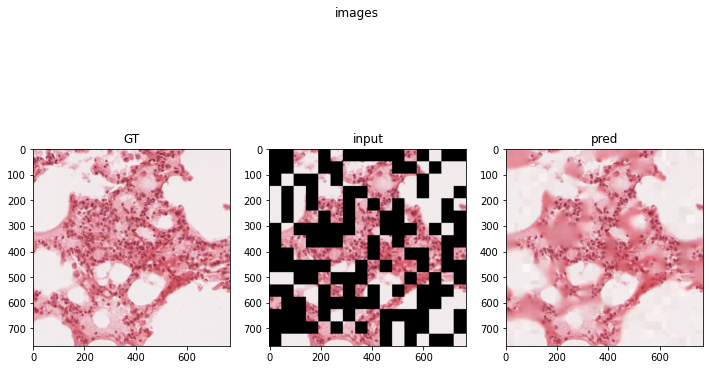

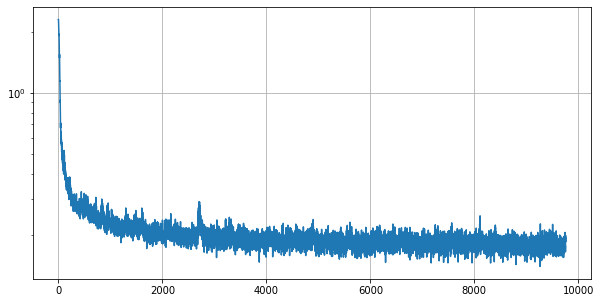

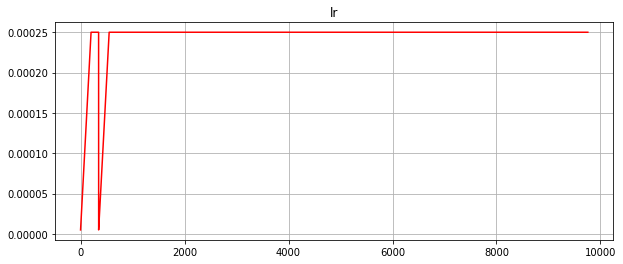

In [52]:
clear_output()
            
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 7))
fig.suptitle('images')
sample = batch['image'][0].detach().cpu().numpy().transpose((1, 2, 0)).astype(np.float32)
ax1.imshow(sample)
ax1.set_title('GT')
mask_rs = cv.resize(batch['mae_mask'][0].detach().cpu().numpy().transpose((1, 2, 0)).astype(np.float32), None, fx=8, fy=8, interpolation=cv.INTER_NEAREST)
#             mask_rs2 = cv.resize(batch['mae_mask'][0].detach().cpu().numpy().transpose((1, 2, 0)), None, fx=8, fy=8, interpolation=cv.INTER_NEAREST)

ax2.imshow(sample * (1 - mask_rs)[:, :, None])
ax2.set_title('input')
ax3.imshow(
    np.clip(
        sample * (1 - mask_rs)[:, :, None] + 
        mask_rs[:, :, None] * cv.resize(pred_image[0].detach().cpu().numpy().transpose((1, 2, 0)).astype(np.float32), (PATCH_SIZE, PATCH_SIZE)),
            #np.array([[[0.229, 0.224, 0.225]]]) + np.array([[[0.485, 0.456, 0.406]]]),
        0.0, 
        1.0).astype(np.float32)
)
ax3.set_title('pred')

plt.figure(figsize=(10, 5))
plt.yscale('log')
plt.plot(train_loss)
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(lr_hist, color='red')
plt.title('lr')
plt.grid()
plt.show()

In [53]:
torch.save(model.state_dict(), os.path.join(
    PTH, 
    'coat-small_ep_{:03d}_lastest.pt'.format(epoch)
))